In [1]:
import pandas as pd
import re

# SOAP

In [2]:
def build_word_boundary_pattern(terms_list):
    """
    Given a list of terms like ["aki", "arf"],
    returns a regex pattern matching any of them as separate words:
    (?:\baki\b)|(?:\barf\b)
    """
    # Make sure each term is escaped, then join with '|'
    # Use word-boundaries (\b) so partial matches like 'wakil' won't match 'aki'
    escaped_terms = [re.escape(term.strip()) for term in terms_list]
    pattern = r'\b(?:' + '|'.join(escaped_terms) + r')\b'
    return pattern

pattern = build_word_boundary_pattern([
        "congestive heart failure", 
        "chf", 
        "hfref", 
        "hfpef", 
        "hf-ref", 
        "hf-pef", 
        "hf ref", 
        "hf pef"
    ])

for s in ["efaefhchf", "ee chf", "congestive failure", "dffahf pef", "chf"]:
    # Convert sentence to lowercase (if that’s how you normally do your matching).
    if re.search(pattern, s.lower()):
        print(f"MATCHED  -> {s}")
    else:
        print(f"NO MATCH -> {s}")

NO MATCH -> efaefhchf
MATCHED  -> ee chf
NO MATCH -> congestive failure
NO MATCH -> dffahf pef
MATCHED  -> chf


/home/yl3427/miniconda3/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/yl3427/miniconda3/lib/python3.10/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

<Figure size 1000x600 with 0 Axes>

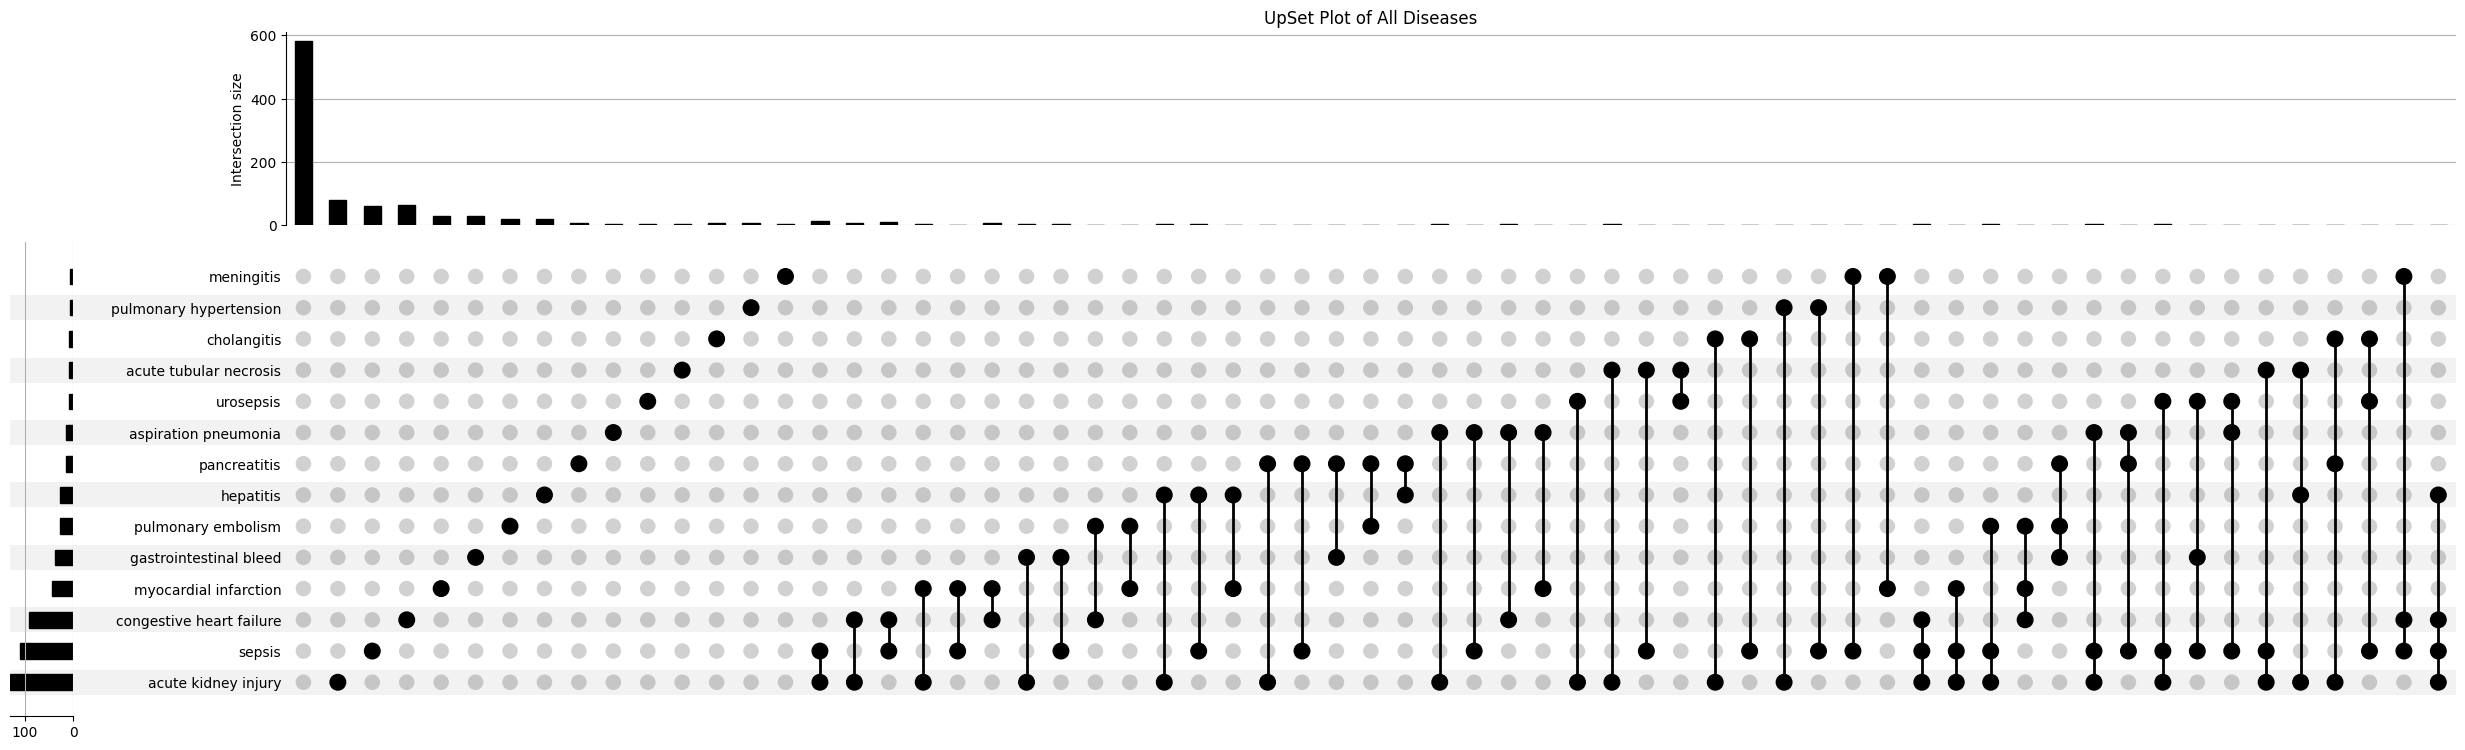

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from upsetplot import from_indicators, plot
import re

#============================#
# 1. LOAD AND PREPARE DATA   #
#============================#

df = pd.read_csv('/home/yl3427/cylab/SOAP_MA/_archive/data/mergedBioNLP2023.csv',
                 usecols=[
                     'File ID',
                     'Subjective',
                     'Objective',
                     'Assessment',
                     'Summary',
                     'cleaned_expanded_Summary',
                     'terms'
                 ])

# Fill NaNs with '' (empty string) and lowercase all text
df = df.fillna('').apply(lambda x: x.str.lower())

# Combine relevant columns into one “combined_summary” for matching.
df['combined_summary'] = df['Summary'] + df['cleaned_expanded_Summary'] + df['terms']


#============================#
# 2. DEFINE MASTER DICTIONARY OF DISEASES #
#============================#

master_prob_dict = {
    'myocardial infarction': [
        "myocardial infarction",
        "elevation mi",
        "non-stemi",
        "nstemi",
        "stemi",
        "nonstemi",
        "non stemi"
    ],
    'congestive heart failure': [
        "congestive heart failure",
        "chf",
        "hfref",
        "hfpef",
        "hf-ref",
        "hf-pef",
        "hf ref",
        "hf pef"
    ],
    'pulmonary embolism': [
        "pulmonary embolism"
    ],
    'pulmonary hypertension': [
        "pulmonary hypertension",
        "pulmonary htn"
    ],
    'sepsis': [
        "sepsis",
        "septic shock"
    ],
    'urosepsis': [
        "urosepsis"
    ],
    'meningitis': [
        "meningitis"
    ],
    'acute kidney injury': [
        "acute kidney injury",
        "aki",
        "acute renal failure",
        "arf"
    ],
    'acute tubular necrosis': [
        "acute tubular necrosis",
        "atn"
    ],
    'pancreatitis': [
        "pancreatitis"
    ],
    'gastrointestinal bleed': [
        "gastrointestinal bleed",
        "gi bleed"
    ],
    'hepatitis': [
        "hepatitis",
        "hep"
    ],
    'cholangitis': [
        "cholangitis"
    ],
    'aspiration pneumonia': [
        "aspiration pneumonia"
    ]
}


#============================#
# HELPER FUNCTION: BUILD WORD-BOUNDARY PATTERN #
#============================#

def build_word_boundary_pattern(terms_list):
    """
    Given a list of terms like ["aki", "arf"],
    returns a regex pattern matching any of them as separate words:
    \b(?:aki|arf)\b
    """
    # Escape all terms, join with '|', and wrap in \b boundaries
    escaped_terms = [re.escape(term.strip()) for term in terms_list]
    pattern = r'\b(?:' + '|'.join(escaped_terms) + r')\b'
    return pattern


#============================#
# 3. CREATE BOOLEAN COLUMNS FOR **ALL** DISEASES #
#============================#
# We'll create columns for every key in master_prob_dict
# so we can visualize everything in the UpSet plot.

for disease_name, terms_list in master_prob_dict.items():
    pattern = build_word_boundary_pattern(terms_list)
    mask = (
        df['combined_summary'].str.contains(pattern, na=False, regex=True) &
        ~df['Subjective'].str.contains(pattern, na=False, regex=True) &
        ~df['Objective'].str.contains(pattern, na=False, regex=True)
    )
    df[disease_name] = mask


#============================#
# 4. VISUALIZE ALL DISEASES WITH UPSET PLOT #
#============================#

all_disease_cols = list(master_prob_dict.keys())  # all boolean columns we just created
binary_df = df[all_disease_cols]
upset_data = from_indicators(binary_df.columns.tolist(), binary_df)

plt.figure(figsize=(10, 6))
plot(upset_data)
plt.title("UpSet Plot of All Diseases")
plt.show()

#---------------------------------------------------#
#     <At this point, you observe the UpSet plot>   #
#  Then decide which diseases you want to keep.     #
#---------------------------------------------------#



In [ ]:
#============================#
# 5. SELECT DISEASES & CREATE A MINI DATASET #
#============================#

# Example: After seeing the plot, you choose a subset:
selected_problems = [
    'congestive heart failure',
    'sepsis',
    'acute kidney injury',
]
# selected_problems = master_prob_dict.keys()  # Use all diseases for now

# Prepare a list to collect mini dataframes
mini_dfs = []

for disease_name in selected_problems:
    # Rebuild the same pattern for the chosen disease
    terms_list = master_prob_dict[disease_name]
    pattern = build_word_boundary_pattern(terms_list)

    # Filter for matching rows
    mask = (
        df['combined_summary'].str.contains(pattern, na=False, regex=True) &
        ~df['Subjective'].str.contains(pattern, na=False, regex=True) &
        ~df['Objective'].str.contains(pattern, na=False, regex=True)
    )
    filtered_df = df[mask]

    # Just take the first 5 for a mini dataset
    # (Use .sample(5, random_state=42) for random selection)
    # sampled_df = filtered_df.head(3)
    sampled_df = filtered_df # keep all rows for now

    print(f"{disease_name}: {sampled_df.shape[0]} rows included.")
    mini_dfs.append(sampled_df)

# Combine everything, removing duplicates by File ID
final_df = pd.concat(mini_dfs).drop_duplicates(subset='File ID')

# Save the mini dataset
out_path = '/home/yl3427/cylab/SOAP_MA/Input/SOAP_all_problems.csv'
final_df.to_csv(out_path, index=False)

print(f"Final mini dataset shape: {final_df.shape}")
print(f"Mini dataset saved to: {out_path}")


myocardial infarction: 44 rows included.
congestive heart failure: 92 rows included.
pulmonary embolism: 28 rows included.
pulmonary hypertension: 7 rows included.
sepsis: 110 rows included.
urosepsis: 9 rows included.
meningitis: 6 rows included.
acute kidney injury: 130 rows included.
acute tubular necrosis: 9 rows included.
pancreatitis: 15 rows included.
gastrointestinal bleed: 37 rows included.
hepatitis: 27 rows included.
cholangitis: 9 rows included.
aspiration pneumonia: 15 rows included.
Final mini dataset shape: (420, 22)
Mini dataset saved to: /home/yl3427/cylab/SOAP_MA/Input/SOAP_all_problems.csv


In [24]:
final_df.iloc[0]['Subjective'] + final_df.iloc[0]['Objective'] + final_df.iloc[0]['Assessment']

'pleuritic right chest pain\n- patient started on coumadin\n- [** 949**] briefly decreased (although unclear whether this was due to\naccidental foley removal), [** 949**] responded appropriately to 500 ml lr\nbolus with [** 949**] 60-70 cc\ns per hour this am\n- patient briefly developed non-gap acidosis with bicarb of 19,\nresolved with substitution of lr for ns for fluid boluses\ns: the patient is feeling well.  her chest pain has entirely resolved.\nshe continues to have dry-mouth as well as her baseline amount of cough\nand shortness or breath.  she has not had n/v diarrhea.  no pain or\nswelling in her legs.\nlosartan\nangioedema/lip\nlisinopril (oral)\ncough;\npenicillins\nitching;\nflagyl (oral) (metronidazole)\nwheezing;\nultram (oral) (tramadol hcl)\nrash;\nreview of systems is unchanged from admission except as noted below\nreview of systems:last dose of antibiotics:\nciprofloxacin - [**2141-7-18**] 08:00 pm\nvancomycin - [**2141-7-19**] 08:02 am\ninfusions:\nheparin sodium 

In [7]:
df = pd.read_csv('/home/yl3427/cylab/SOAP_MA/Input/SOAP_5_problems.csv')
len(df)

351

# MedicalQA 데이터, 5지선다만 골라내기

In [ ]:
!conda update pandas

In [2]:
import pandas as pd
import re

# Read each CSV file into a DataFrame
df1 = pd.read_csv('/home/yl3427/cylab/SOAP_MA/Input/step1_ALL.csv', encoding="utf-8")
df2 = pd.read_csv('/home/yl3427/cylab/SOAP_MA/Input/step2_ALL.csv', encoding="utf-8")
df3 = pd.read_csv('/home/yl3427/cylab/SOAP_MA/Input/step3_ALL.csv', encoding="utf-8")

# Reassign the qn_num values with a prefix for each file
df1['qn_num'] = '1_' + df1['qn_num'].astype(str)
df2['qn_num'] = '2_' + df2['qn_num'].astype(str)
df3['qn_num'] = '3_' + df3['qn_num'].astype(str)

# Concatenate the DataFrames into one
merged_df = pd.concat([df1, df2, df3], ignore_index=True)

# Optionally, view the merged DataFrame
print(len(merged_df))

# Filter rows based on the rule
filtered_rows = []

for _, row in merged_df.iterrows():
    matches = re.findall(r'\b[A-Z](?=[.:])', row['choice'])
    if set(matches) == {'A', 'B', 'C', 'D', 'E'}:
        filtered_rows.append(row)

# Convert the list of rows to a new DataFrame
filtered_df = pd.DataFrame(filtered_rows)

# Optionally, view the new DataFrame
print(len(filtered_df))
filtered_df.to_csv('/home/yl3427/cylab/SOAP_MA/Input/filtered_merged_QA.csv', index=False, encoding="utf-8", lineterminator="\n")

376
284


# TNM dataset (Do not use)

In [ ]:
# df = pd.read_csv('/secure/shared_data/rag_tnm_results/summary/5_folds_summary/brca_df.csv')

# data_lst = []
# for i, row in df.iterrows():
#     pathology_report = row["text"]
#     ground_truth = row["t"]
#     filename = row["patient_filename"]

#     question_text = f"""
#     Based on the following pathology report for a breast cancer patient, determine the pathologic T stage (T1, T2, T3, or T4) for breast cancer, according to the AJCC Cancer Staging Manual (7th edition). 
#     Choose from T1, T2, T3, T4.

#     {pathology_report}
#     """
#     data = {"Question": question_text, "Answer": ground_truth, "Filename": filename}
#     data_lst.append(data)